## Pulse Switching Normalized Data Analysis Notebook

### Read Me
    1. This notebook should be run from the top cell down.  Running in a different order will cause errors.
    2. All values that may need to be edited will appear in the cell immediately following this one.
    3. This cell normalizes the y data from [-1,1] and then searches for the two closest points surrounding y = 0 and then solves for x at y=0
    4. This notebook will fail for cases where data is too noisy (crosses the y=0 line more than 2 times)

In [2]:
# * represents wildcard characters, desired file name types should be typed explicitly surrounded by *, ie: *desired_field*
# for positive current values make sure to preface with an underscore to avoid also getting negative in-plane fields, ie: _400
directory = r'C:\Users\Neuromancer\Desktop\Pulse Switching Sample Data\*_-100.0Oe*'

# Device characteristics
w = 1e-9 # device width (meters)


[1.79632405 1.79637796 1.79678813 1.79693542 1.79631579 1.797631
 1.79773355 1.7978201  1.79963982 1.80288829 1.80930934 1.83041639
 1.85545524 1.88585529 1.90672545 1.92686109 1.937797   1.94808059
 1.95575634 1.96145635 1.96649126 1.9680409  1.97019835 1.9682507
 1.96985942 1.96832847 1.96885382 1.96710147 1.96845702 1.96745941
 1.966954   1.9663811  1.96653609 1.96539001 1.9660786  1.96438827
 1.96558238 1.96585734 1.96432893 1.96354847 1.96357583 1.96255609
 1.96267886 1.96218073 1.96359574 1.96020526 1.95737483 1.95327641
 1.93863748 1.90796229 1.87378162 1.85698834 1.8418394  1.83049779
 1.81831421 1.81055814 1.80391255 1.80163509 1.79948008 1.79634679
 1.79564035 1.79387467 1.7950332  1.7942178  1.79483764 1.79511077
 1.79566349 1.79458474 1.7951227  1.79551359 1.7964666  1.79656017
 1.79604815 1.79631636 1.79605763 1.79709418 1.79553862 1.79504644
 1.79621146 1.79707414 1.79699318]
[-0.97221723 -0.97160574 -0.96695328 -0.9652826  -0.97231092 -0.95739279
 -0.95622959 -0.95524787

<IPython.core.display.Javascript object>


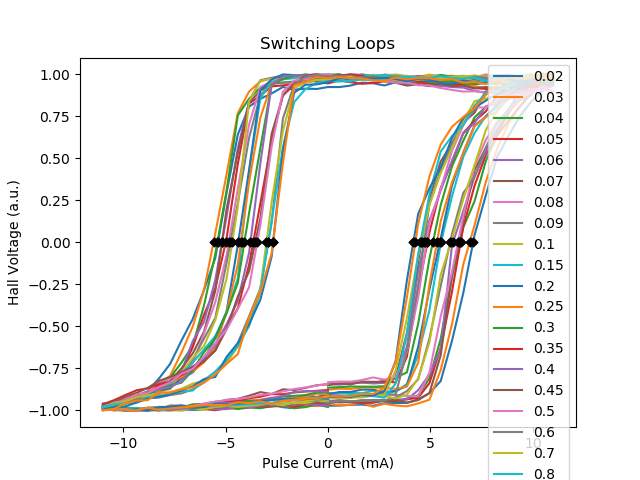

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
import glob as glob


FileList = []


# takes filepath and returns float current pulse length(s) value
def getCurrent(file):
    for x in file.split('_'):
        if x.endswith('s'):
            return (float(x[0:(len(x) - 1)]))
        
# takes file and unpacks data from it so it can be graphed in matplotlib, returns numpy array
def unpack(file, array):
    f = np.loadtxt(file, delimiter=None, skiprows=6, usecols=(1,2))
    index = array.shape[1] #index of where to add t to array
    #loop to find first empty column in the array
    for n in range(0, array.shape[1]):
        if (array[:, n]==0).all() and (index > n):
            index = n
    
    # if index == 0, then add both x and y data, otherwise add y data only
    if (index == 0):
        array[0:array.shape[0],index:2] += f
        #print('first addition')
    else:
        array[0:array.shape[0],index] += f[0:array.shape[0], 1]
        #print('more data added at', index)
    
    return array
                
# finds the length of file data and number of files, returns as tuple
def dataSize():
    q = np.loadtxt(FileList[0][0], delimiter=None, skiprows=6, usecols=(0))
    return ((q.shape[0], len(FileList)+1))

# normalizes an array passed to it and returns the normalized version (from -1 to 1)
def normalize(array):
    normed = (((array - array.min(0)) / array.ptp(0)) - 0.5) * 2
    print(normed[:,0])
    return normed

# searches through directory and creates list of tuples (filepath, float(current))
for j in glob.glob(directory):
    FileList.append((j, getCurrent(j)))
    
# sort tuple list by current
FileList.sort(key=lambda tup: tup[1])

#initialize Dataset to array of all 0's
DataSet = np.zeros(dataSize())

#creates tuples of numpy array and corresponding current value
for x in FileList:
    DataSet = unpack(x[0], DataSet)

print(DataSet[:, 1])
#normalize all hall voltage values
DataSet[:, 1:] = normalize(DataSet[:, 1:])

    
# Lists all currents and files pulled
print('Pulse Length (s)    Switching Loop files in current folder')
for x in FileList:
    print(x[1], '       ', x[0])

# half of data, 1 peak per half
h = int(DataSet.shape[0]/2) # will round down if odd number of points
adj = 0 # adjustment factor for indexing
if DataSet.shape[0] % 2 == 0:
    adj = 0
else: 
    adj = 1

    
clow = np.zeros(DataSet.shape[1]-1) # -Hz value closest to y = zero
chigh = np.zeros(DataSet.shape[1]-1) # +Hz value closest to y = zero
norm_v = np.zeros(DataSet.shape[1]-1) # all zeros for easy graphing
ind_low = np.zeros(DataSet.shape[1]-1) # low index of lower bound
ind_l = np.zeros(DataSet.shape[1]-1) # low index of higher bound
ind_high = np.zeros(DataSet.shape[1]-1) # high index  of lower bound
ind_h = np.zeros(DataSet.shape[1]-1) # high index of higher bound

#function that looks for sign change in data points and pulls index from those points
def find_nearest(array):
    asign = np.sign(array)
    if asign.any() == 0.0:
        idx = np.where(asign == 0.0)
        print('zero index at: ', inx[0])
        return idx[0], idx[0]
    else:
        signchange = (np.roll(asign, 1) - asign)
        signchange[0] = 0 # account for the fact that roll one compares sign change of 1st and last element of asign
        idx = np.where(signchange != 0)
        return idx[0]-1, idx[0]


# finds min/max indexes of the arrays (n and m), then appends index to clow/chigh
for x in range(1, DataSet.shape[1]):
    print(DataSet[:, x])
    n = DataSet[:h, x]
    m = DataSet[h + 1:, x]
    ind_low[x-1], ind_l[x-1] = find_nearest(n) # finds -Hz index values closest to y = 0
    ind_high[x-1], ind_h[x-1] = find_nearest(m) # finds +Hz index values closest to y = 0

ind_high += h+adj # adjust index for array split in half
ind_h += h+adj # adjust index for array split in half


# find y intercept of each set
for j in range(ind_high.shape[0]):
    # get slope and intercept from low and high bounds
    if ind_low[j] == ind_l[j]: # only occurs when exactly 0
        clow[j] = DataSet[int(ind_low[j]), 0]
    else:
        low_x = DataSet[int(ind_low[j]):int(ind_l[j])+1, 0]
        low_y = DataSet[int(ind_low[j]):int(ind_l[j])+1, j+1]
        m_l, b_l = np.polyfit(low_x, low_y, 1)
        clow[j] = -b_l / m_l # - Hc value at y = 0
    if ind_high[j] == ind_h[j]:
        chigh[j] = DataSet[int(ind_high[j]), 0]
    else:
        high_x = DataSet[int(ind_high[j]):int(ind_h[j])+1, 0]
        high_y = DataSet[int(ind_high[j]):int(ind_h[j])+1, j+1]
        m_h, b_h = np.polyfit(high_x, high_y, 1)
        chigh[j] = -b_h / m_h # + Hc value at y = 0

    
# plot loops    
plt.figure()
for i in range(1, DataSet.shape[1]):
    plt.plot(DataSet[:,0], DataSet[:,i], label=str(FileList[i-1][1]), zorder=0)

# plot Hc points found
plt.scatter(clow, norm_v, s=20, c='black', marker='D', zorder=1)
plt.scatter(chigh, norm_v, s=20, c='black', marker='D', zorder=1)

#matplotlib plot commands
plt.title('Switching Loops')
plt.xlabel('Pulse Current (mA)')
plt.ylabel('Hall Voltage (a.u.)')
plt.legend()
plt.show()

Pulse Length (s)  [0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.15 0.2  0.25 0.3  0.35
 0.4  0.45 0.5  0.6  0.7  0.8  0.9  1.  ]
Low Fitted Line - Slope:  -0.7456765338863822 Low Intercept:  19.65765850600138
Low Intercept / Slope:  26.36217932666846
Low values: [7.08091034 6.91031947 6.43536894 6.46804368 6.09874422 6.37279703
 6.34075234 5.96084676 5.99882869 5.51086742 5.45606017 5.31491631
 5.11651669 4.85299236 4.70954657 4.5644675  4.80721918 4.68917186
 4.54369576 4.50770718 4.16372076 4.26139534]
High Fitted Line - Slope:  0.7761698677831393 High Intercept:  -18.936701720843228
High Intercept / Slope:  24.397625451409706
High values: [-5.36717085 -5.58609865 -5.39862394 -4.99135907 -5.17253849 -5.17315789
 -4.84186228 -4.76110985 -4.67309823 -4.21507195 -4.38156008 -4.25266164
 -4.08116895 -3.6503343  -3.78729038 -3.55031508 -3.45270737 -2.91462163
 -3.00360629 -2.91773041 -2.67628973 -2.68427059]


<IPython.core.display.Javascript object>


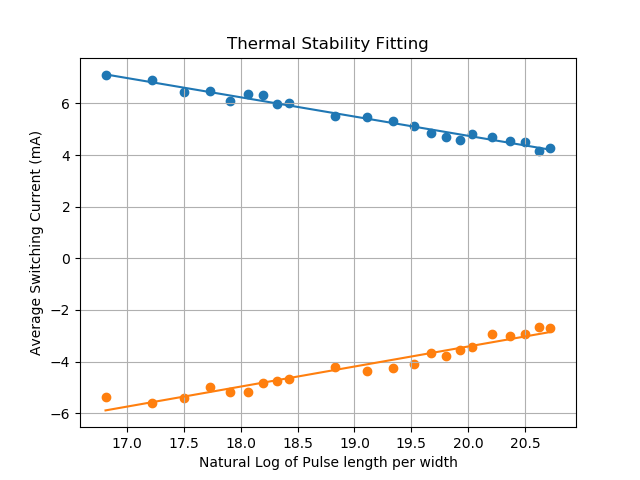

In [6]:
%matplotlib notebook
import math
from scipy import optimize
#Analyzer Code

cmean = np.zeros(DataSet.shape[1]-1) # mean array initialization
# find mean values
for x in range(chigh.shape[0]):
    cmean[x] = (abs(chigh[x]) + abs(clow[x]))/2
    

x_val = np.array([x[1] for x in FileList]) # array of current values
print('Pulse Length (s) ', x_val)
x_val = np.log(x_val / w)


# scipy fitting using non-linear least squares fit 
def test_func(x, m, b): # test of linear fit, x variables, slope m, b intercept
    return (m * x) + b

lparams, lparams_covariance = optimize.curve_fit(test_func, x_val, clow) # returns m and b values as params, covariance of fit
print('Low Fitted Line - Slope: ', lparams[0], 'Low Intercept: ', lparams[1])
print('Low Intercept / Slope: ', -lparams[1] / lparams[0])
print('Low values:', clow)

hparams, hparams_covariance = optimize.curve_fit(test_func, x_val, chigh) # returns m and b values as params, covariance of fit
print('High Fitted Line - Slope: ', hparams[0], 'High Intercept: ', hparams[1])
print('High Intercept / Slope: ', -hparams[1] / hparams[0])
print('High values:', chigh)


# matplotlib plot commands
plt.scatter(x_val, clow)
plt.scatter(x_val, chigh)
plt.plot(x_val, test_func(x_val, *lparams))
plt.plot(x_val, test_func(x_val, *hparams))
plt.grid(True)
plt.title('Thermal Stability Fitting')
plt.xlabel('Natural Log of Pulse length per width')
plt.ylabel('Average Switching Current (mA)')
plt.show()